# Classification Problems

First I'll download the MNIST dataset.
The MNIST dataset is a set of 70.000 small images of digits handwritten by high school students and employees of the US Census Bureau.

Each image is labeled with the digit it represents.

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Download the MNIST dataset with the functions provided by Scikit Learn.
from sklearn.datasets import fetch_mldata
mnist_data = fetch_mldata('MNIST original')

In [4]:
mnist_data # Show the mnist_data

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

Information about each key of the dataset's map:
  * 'DESCR': Description of the dataset
  * 'data': Contains an array with one row per instance and one column per feature.
  * 'target': Contains an array with the labels


In [5]:
data, labels = mnist_data['data'], mnist_data['target'] # separate the data and the labels

In [6]:
data.shape # the data consists of 70.000 images and 784 features (in this case each feature is a pixel)

(70000, 784)

In [7]:
labels.shape # there are 70.000 labels (one for each image, so for a given number n: data[n] represents label[n])

(70000,)

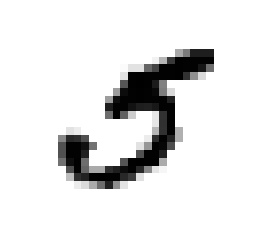

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = data[36000] # choose a random image from the dataset
some_digit_image = some_digit.reshape(28, 28) # reshape it to a 28x28 image.

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [9]:
labels[36000] # let's check the label for that image!

5.0

Now we need to create a test set and a training set for each array. The MNIST dataset is already separated, the first 60.000 images are the training set and the last 10.000 images are the train set.

Then we need to shuffle the training set, this will guarantee that all cross-validation folds will be similar.
Some algorithms are sensitive to the order of the training instances and they perform poorly if they get many similiar instances in a row. Shuffling the dataset ensures this won't happen. But shuffling is not a silver bullet. In some contexts you can't shuffle the dataset because of the nature of the dataset (times series data, like stock market prices and weather related data).

In [10]:
data_train, data_test, labels_train, labels_test = data[:60000], data[60000:], labels[:60000], labels[60000:]

In [11]:
# shuffling
import numpy as np

shuffle_index = np.random.permutation(60000) # generate a random permutation of the indices
data_train, labels_train = data_train[shuffle_index], labels_train[shuffle_index] # permutate the elements

## Training a Binary Classifier

Let's train a binary classifier that detects if a given image is a 5 or not.
For that task we are going to use a Stochastic Gradient Descent (SGD) classifier using the SGDClassifer class from Scikit-Learn.
This classifier can handle a lot of data efficiently. It's also suitable for online learning.

In [12]:
labels_train_5 = (labels_train == 5) # gets an array of booleans telling if each element is equal to five
labels_test_5 = (labels_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

RANDOM_STATE = 42 # fix the state to get reproducible results

sgd_classifier = SGDClassifier(max_iter=5, random_state = RANDOM_STATE)
sgd_classifier.fit(data_train, labels_train_5) # trains the model

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
sgd_classifier.predict([some_digit]) # it works!

array([False])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### K-Fold Cross-Validation
In k-fold cross validation the original training set is partitioned into k subsets (named folds) of size $ m/k $ (for simplicity, assume that $ m/k $ is an integer). For each fold, the algorithm is trained on the union of the other folds and then the error of its output is estimated using the fold. Finally, the average of all of these errors is the estimate of the true error. 
$$ error = \frac{1}{K} \sum_{i=1}^{K} error_{i} $$
K-Fold cross validation is often used for model selection and parameter tuning. Once the best parameter is chosen, the algorithm is retrained using this parameter on the entire training set.
![k-fold Cross Validation with k = 4](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions. 


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(data_train, labels_train_5):
    clone_classifier = clone(sgd_classifier) # clone the classifier
    data_train_folds = data_train[train_index]
    labels_train_folds = labels_train_5[train_index]
    data_test_fold = data_train[test_index]
    labels_test_fold = labels_train_5[test_index]
    
    clone_classifier.fit(data_train_folds, labels_train_folds) # train the cloned clf.
    label_predict = clone_classifier.predict(data_test_fold)
    n_correct = sum(label_predict == labels_test_fold)
    print(n_correct / len(label_predict))

0.96125
0.9551
0.9596


In [16]:
# Now using the tools from sklearn, it should be the same as doing it manually
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, data_train, labels_train_5, cv = 3, scoring = 'accuracy')

array([0.96125, 0.9551 , 0.9596 ])

Accuracy is generally not the preferred performance measure for classifiers because they doesn't work well on skewed datasets (i.e. when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as B.

In [17]:
from sklearn.model_selection import cross_val_predict

labels_train_pred = cross_val_predict(sgd_classifier, data_train, labels_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

# Each row in the confusion matrix represents an actual class.
# While each column represents a predicted class.
confusion_matrix(labels_train_5, labels_train_pred)

array([[53415,  1164],
       [ 1317,  4104]])

In [24]:
labels_train_perfect_predictions = labels_train_5
confusion_matrix(labels_train_5, labels_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The first row of this matrix considers non-5 images (the __negative class__): 53.985 of them were correctly classified as non-5s (they are called __true negatives__), while the remaining 594 were wrongly classified as 5s (__false positives__). The second row considers the images of 5s (the __positive class__): 1875 were wrongly classified as non-5s (__false positives__), while the remaining 3546 were correctly classified as 5s (__true positives__).
A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal.

The confusion matrix gives a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the __precision__ of the classifier:
$$ precision = \frac{TP}{TP + FP} $$ 
Where 
  - TP: Number of true positives
  - FP: Number of false positives
  
Precision is tipically used along with another metric called __recall__ or __sensibility__ or __true positive rate (TPR)__. This is the ratio of positive instances that are correctly detected by the classifier:
$$ recall = \frac{TP}{TP + FN} $$

In [20]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(labels_train_5, labels_train_pred)
rec_score = recall_score(labels_train_5, labels_train_pred)
print("Precision Score: {}".format(prec_score))
print("Recall Score: {}".format(rec_score))

Precision Score: 0.7790432801822323
Recall Score: 0.7570558937465413


It is often convenient to combine precision and recall into a single metric called the $ F_{1} $ score, in particular if you need a simple way to compare 2 classifiers. The $ F_{1} $ score is the __harmonic mean__ of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $ F_{1} $ score if both recall and precision are high
$$ F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}} $$

In [21]:
from sklearn.metrics import f1_score

f1 = f1_score(labels_train_5, labels_train_pred)
print("F1 Score: {}".format(f1))

F1 Score: 0.76789222565254


### Precision/Recall Tradeoff

Unfortunately, increasing precision reduces recall and viceversa.


In [22]:
labels_scores = sgd_classifier.decision_function([some_digit])
labels_scores

array([-22977.51908037])

### The ROC Curve

The __Receiver operating charasteristic__ (ROC) curve is another common tool used with binary classifiers.It plots the recall (TPR) against the __false positive rate__ (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the __true negative rate__ (TNR). Wich is the ratio of negative instances that are incorrectly classified as negative. The TNR is also called __specificity__. Hence the ROC curve plots $ recall $ vs $1 - specificity$.

One way to compare classifiers is to measure the __area under the curve__ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

The ROC Curve is similar to the PR Curve but, as a rule of thumb: you should prefer the PR curve whenever __the positive class is rare__ or when __you care more about the false positives than the false negatives__ and __the ROC Curve otherwise__.

## Multiclass Classification
